# Predictive modeling for length of stay

Here, I will demonstrate how to perform supervised, predictive modeling using spatial parameters as an input and length of stay as an output.

In [1]:
#standard
import pandas as pd
import janitor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

#Model
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support, r2_score, mean_squared_error

#interpretation
import eli5
from eli5.sklearn import PermutationImportance
from eli5.formatters.as_dataframe import format_as_dataframes

#Computational performance
from timeit import default_timer as timer

#Sampling
from scipy.stats import gamma


First, I'll import the data. I'm going to import data which was already somewhat cleaned (removed irrelevant features, made titles nice).

In [2]:
df = pd.read_csv('Data/aggregated_simulated_outcomes.csv')
df = df.drop(columns='index')
df.head()

,room_depth,dist_to_elevator,dist_to_nurse_station,head_isovist,door_isovist,sink_isovist,fall_prob,fall,delirium_prob,has_delirium,summed_mean,sampled_LOS,view_type
0,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0.0125,0.132,0.1625,3.761661,3.665700,hardscape
1,0.464286,99.592921,19.918584,548.296155,636.071360,374.817764,0.009,0.0125,0.176,0.1625,3.761661,3.795298,building
2,0.257143,153.002567,67.301283,436.017976,493.723516,343.912753,0.018,0.0125,0.132,0.1375,3.311095,3.370062,greenery
3,0.300265,201.873097,119.523355,445.453332,498.349012,347.664951,0.018,0.0625,0.132,0.1375,3.394298,3.473077,greenery
4,0.301149,220.303850,122.501283,436.017976,493.723516,343.912753,0.018,0.0250,0.132,0.1875,3.833269,3.585154,hardscape


I thought that either Random Forest Regression or Gradient Boosting regression would work well for our objective: identifying important, but not necessarily linear, relationships.

### Splitting data

In [3]:
features = ['view_type', 'room_depth', 'dist_to_elevator',
           'dist_to_nurse_station', 'head_isovist', 'door_isovist',
            'sink_isovist']
X = (
    df
    .loc[:, features]
    .expand_column('view_type', sep=', ')
    .drop(columns=['view_type', 'sink_isovist'])
)
y = df['sampled_LOS']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Random forest or gradient boosting?

In [5]:
def get_model_scores(estimator, X, y):
    y_preds = cross_val_predict(estimator, X_train, y_train, cv=5)
    scores = cross_val_score(estimator, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    return mean_score, std_score

In [6]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
gb_reg = GradientBoostingRegressor(n_estimators=100, random_state=42)
mean_score_rf, std_score_rf = get_model_scores(rf_reg, X_train, y_train)
mean_score_gb, std_score_gb = get_model_scores(gb_reg, X_train, y_train)

print(f'Random Forest cross validation had a mean MSE of {mean_score_rf} with standard deviation {std_score_rf}.')
print(f'Gradient Boosting cross validation had a mean MSE of {mean_score_gb} with standard deviation {std_score_gb}.')

Random Forest cross validation had a mean MSE of -0.06905848413971045 with standard deviation 0.0016572393018911297.
Gradient Boosting cross validation had a mean MSE of -0.06410061370634101 with standard deviation 0.0012526591699086268.


Gradient Boosting seems to be working quite a bit better than Random Forest, so let's go with that. Let's find some good model parameters for now. We can start by finding a good number of trees to use.

### Tuning hyperparameters

First, I would like to try to determine the right number of estimators to use with default parameters.

In [7]:
estimators = [10, 50, 100, 250, 500]
all_means = []
all_std = []
for estimator in estimators:
    gb_test = GradientBoostingRegressor(n_estimators=estimator, random_state=42)
    mean_score, std_score = get_model_scores(gb_test, X_train, y_train)
    all_means.append(mean_score)
    all_std.append(std_score)   

Text(0, 0.5, 'negative mean squared error')

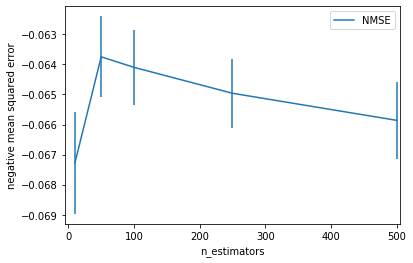

In [8]:
model_df = pd.DataFrame({'n_estimators': estimators, 'NMSE': all_means, 'St Dev': all_std})
ax = model_df.plot(x='n_estimators', y='NMSE', yerr='St Dev')
ax.set_xlim((-5, 505))
ax.set_ylabel('negative mean squared error')

In [9]:
estimators = [10, 20, 30, 40, 50, 75, 100]
all_means = []
all_std = []
for estimator in estimators:
    gb_test = GradientBoostingRegressor(n_estimators=estimator, random_state=42)
    mean_score, std_score = get_model_scores(gb_test, X_train, y_train)
    all_means.append(mean_score)
    all_std.append(std_score)  

Text(0, 0.5, 'negative mean squared error')

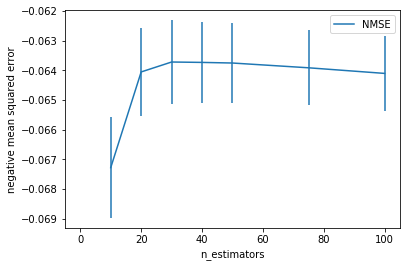

In [10]:
model_df = pd.DataFrame({'n_estimators': estimators, 'NMSE': all_means, 'St Dev': all_std})
ax = model_df.plot(x='n_estimators', y='NMSE', yerr='St Dev')
ax.set_xlim((-5, 105))
ax.set_ylabel('negative mean squared error')

30 estimators looks great! Let's stick with that. Now let's mess with tree depth, which is important for looking at interaction between variables. Since I didn't code any relationships in between variables, we don't expect a huge bump in model performance if I increase the max depth, but this would be an important hyperparameter to tune in the future. Since we're not 100% sure how many data points we'll eventually have in the data, we won't mess around with things like min samples to split a branch.

In [11]:
max_depth = list(range(2,10))
all_means = []
all_std = []
for depth in max_depth:
    gb_test = GradientBoostingRegressor(n_estimators=30, max_depth=depth, random_state=42)
    mean_score, std_score = get_model_scores(gb_test, X_train, y_train)
    all_means.append(mean_score)
    all_std.append(std_score)  


Text(0, 0.5, 'negative mean squared error')

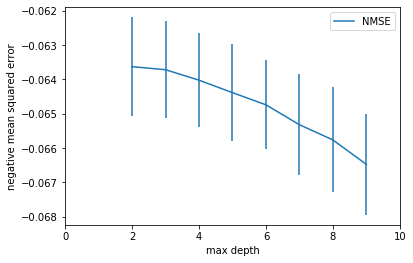

In [12]:
model_df = pd.DataFrame({'max depth': max_depth, 'NMSE': all_means, 'St Dev': all_std})
ax = model_df.plot(x='max depth', y='NMSE', yerr='St Dev')
ax.set_xlim((0, 10))
ax.set_ylabel('negative mean squared error')

As expected, performance drops when we added in more features. We can just keep it at 3 for now, which is the default. If we wanted to hyperparameter tune more extensively, we could mess around with learning rate (especially if the number of estimators that we found to be optimal were fewer than 20 or greater than 100), and the maximum number of features to consider for a split. This is pretty easily searchable through a random search CV or grid search CV (implemented on scikit-learn).

### Model Performance

Now we have the model we want to use for now:

In [13]:
gb_reg = GradientBoostingRegressor(n_estimators=30, max_depth=3, random_state=42)

Let's fit it to our training data, run it on our test data, and see how it performs!

0.3361136494035917

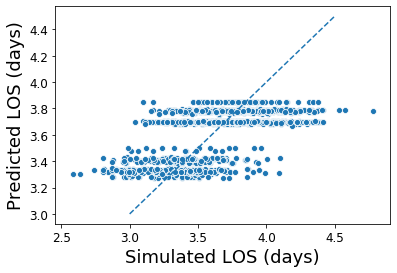

In [14]:
gb_reg.fit(X_train, y_train)
y_preds = gb_reg.predict(X_test)
y_stay_scatter = pd.DataFrame({'y_truth': y_test, 'y_predicted': y_preds, 'target': 'length_of_stay'})
plt.plot([3, 4.5], [3, 4.5], linestyle='--')
ax = sns.scatterplot(data=y_stay_scatter, x='y_truth', y='y_predicted')
plt.xlabel('Simulated LOS (days)', fontsize=18)
plt.ylabel('Predicted LOS (days)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
r2_score(y_test, y_preds)

In [15]:
mean_squared_error(y_test, y_preds)

0.06431452470485925

This model performance is not that much different from our cross-validation, which is to be expected considering crossvalidation is the average performance of 5 different models. 

### Feature importances

Although scikit-learn has feature importances built into a lot of it's estimators, I decided to use ELI5 to do permutation importance testing. This way, I could get a sense of the variability of contribution of each feature to the model.

In [16]:
X.columns

Index(['room_depth', 'dist_to_elevator', 'dist_to_nurse_station',
       'head_isovist', 'door_isovist', 'building', 'greenery', 'hardscape'],
      dtype='object')

In [17]:
#custom functions for getting and plotting feature importance
def get_feature_importances(fitted_model, X, y, labels):
    perm = PermutationImportance(fitted_model).fit(X, y)
    exp = eli5.explain_weights(perm, feature_names=labels)
    importance_err_df = format_as_dataframes(exp)['feature_importances'].rename_column('weight', 'importance')
    return importance_err_df

def plot_feature_importances(importance_df):
    ax = importance_df.plot(x='feature', y='importance', yerr='std', kind='bar')
    ax.set_ylabel('importance')

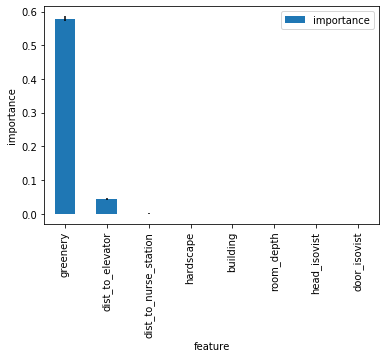

In [18]:
gb_importances = get_feature_importances(gb_reg, X_test, y_test, list(X.columns))
plot_feature_importances(gb_importances)

Greenery is most evident in this analysis, while distance to the elevator and nurse station are much less evident. For modeling rare events like delirium or falls, it may be important to also aggregate patient data by demographic, like age or medical complication.

### Impact of sample size on ability to identify feature importances

I will expand more on what I'm doing here later, but in short I'm undersampling from the 10,000 rooms and evaluating how feature importance changes. I find that by 500-1000 rooms I can resolve greenery and distance to elevator as important.

In [19]:
def get_undersampled_test_train_split(X, y, n=None):
    if n==None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42) 
        return X_train, X_test, y_train, y_test
    X_and_y = pd.concat([X, y], axis=1)
    X_and_y_undersampled = X_and_y.shuffle(random_state=42).iloc[:n, :]
    X_undersampled = X_and_y_undersampled.iloc[:, :-1]
    y_undersampled = X_and_y_undersampled.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
        X_undersampled, y_undersampled, test_size=0.2, random_state=42)   
    return X_train, X_test, y_train, y_test

In [21]:
n = [100, 300, 500, 1000, 2000, 5000, 7500, 10000]
all_importances = []
for n in n:
    X_train, X_test, y_train, y_test = get_undersampled_test_train_split(X, y, n)
    gb_reg_samples = GradientBoostingRegressor(n_estimators=30, max_depth=3, random_state=42)
    gb_reg_samples.fit(X_train, y_train)
    gb_stay_importances = get_feature_importances(gb_reg_samples, X_test, y_test, list(X.columns))
    r2 = r2_score(y_test, gb_reg_samples.predict(X_test))
    gb_stay_importances = gb_stay_importances.add_columns(sample_size=n, r2=r2)
    all_importances.append(gb_stay_importances)


In [22]:
importances_df = pd.concat(all_importances, axis=0)

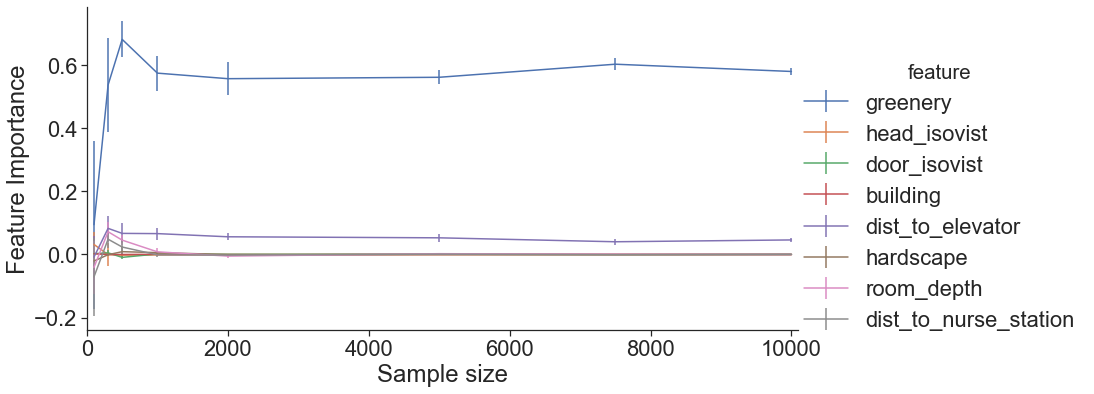

In [24]:
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="line", ax=ax, **kwargs)

sns.set(style='ticks', font_scale=2)
g = sns.FacetGrid(importances_df, 
                  hue='feature', height=6, aspect=2)
g = (
    (g.map_dataframe(errplot, "sample_size", "importance", "std")
    .set(xlabel='Sample size', ylabel='Feature Importance', xlim=(0, 10100)))
).add_legend()



Now to determine the direction of this importance, you can just look at distributions of LOS for categorical varibales (like greenery) or scatter plots for numerical variabls.

### Impact of variance of distribution

I need to simulate the data from gamma distributions with a range of variances. To do this, I need my 800,000 patient matrix. Since this file is huge to save, I'll just generate it again in code (for more notes on how I did this, see the synthesis notebook).

In [25]:
#read in data and clean
data_fn = 'Data/190508_Output.csv'
df = pd.read_csv(data_fn)
clean_df = (
    df
    .clean_names(case_type='snake')
    .drop(columns=['is_greenery', 'is_building', 
                   'is_parking', 'na', 'na_1',
                  'room_coordinate_x', 'room_coordinate_y',
                  'img_path', 'room_area', 'length_of_stay',
                  'pain_medicine', 'med_error', 
                   'complication_rate'])
    .encode_categorical('view_type')
)
clean_df.head()

#making n=800000 matrix
repeat_index = np.repeat(np.arange(len(clean_df)), 80)
clean_df_full = clean_df.iloc[repeat_index].reset_index()

#important variables
mean_LOS = 4.5

#declaring fall probs, second line is transforming to 
falls_per_1000_patient_days = 4
falls_per_patient = falls_per_1000_patient_days / 1000 * mean_LOS
falls_with_nurse_close = falls_per_patient * (1 - 0.5)

#making filter for nurse station
close_nurse_station = clean_df_full.dist_to_nurse_station < 60

#adding probs based of nurse station
fall_prob_feature = ((falls_per_patient * ~close_nurse_station)
                         + (falls_with_nurse_close * close_nurse_station))
clean_df_full = clean_df_full.add_column('fall_prob', fall_prob_feature)

# fall simulation
np.random.seed(123)
random_nums_fall = np.random.rand(clean_df_full.shape[0])
fall = random_nums_fall < fall_prob_feature
clean_df_full = clean_df_full.add_column('fall', fall.astype('int'))

#declaring delirium probs
wake_risk_very_close = 0.22
wake_risk_close = wake_risk_very_close * 0.8
baseline = 0.22 * 0.6

#making filter for elevator values
very_close_filter = clean_df_full.dist_to_elevator < 50
close_filter = (clean_df_full.dist_to_elevator >= 50) & (clean_df_full.dist_to_elevator < 100)
far_filter = clean_df_full.dist_to_elevator >= 100

#adding probs based off of elevator
delirium_prob_feature = ((wake_risk_very_close * very_close_filter)
                         + (wake_risk_close * close_filter)
                         + (baseline * far_filter))                   
clean_df_full = clean_df_full.add_column('delirium_prob', delirium_prob_feature)

# delirium simulation
np.random.seed(42)
random_nums_delirium = np.random.rand(clean_df_full.shape[0])
has_delirium = random_nums_delirium < delirium_prob_feature
clean_df_full = clean_df_full.add_column('has_delirium', has_delirium.astype('int'))

# contribution of trees
tree_average = 7.96
no_tree_average = 8.7
tree_exp_mean = (tree_average + no_tree_average) / 2
tree_diff = tree_average - tree_exp_mean 
no_tree_diff = no_tree_average - tree_exp_mean
weighted_greenery_modifier = tree_diff * (mean_LOS / tree_exp_mean)
weighted_no_greenery_modifier = no_tree_diff * (mean_LOS / tree_exp_mean)
#arrays for trees
greenery_modifier_array = ((clean_df_full.view_type=='greenery')*weighted_greenery_modifier
                           + ~(clean_df_full.view_type=='greenery')*weighted_no_greenery_modifier)

# contribution of fall
fall_average = 37.2
no_fall_average = 25.7
fall_study_mean = (292/622) * 37.2 + (330/622) * 25.7

fall_modifier = ((fall_average - fall_study_mean) / fall_study_mean) * mean_LOS
no_fall_modifier = ((no_fall_average - fall_study_mean) / fall_study_mean) * mean_LOS

fall_modifier_array = ((clean_df_full.fall==1) * fall_modifier
                       + (clean_df_full.fall==0) * no_fall_modifier)


#contribution of delirium
del_study_mean_LOS = 6.2
del_pos_LOS = 8.3
del_neg_LOS = 5.5

delirium_modifier = (del_pos_LOS - del_study_mean_LOS) / del_study_mean_LOS * mean_LOS
no_delirium_modifier = (del_neg_LOS - del_study_mean_LOS) / del_study_mean_LOS * mean_LOS

delirium_modifier_array = ((clean_df_full.has_delirium==1) * delirium_modifier
                           + (clean_df_full.has_delirium==0) * no_delirium_modifier)

#creating the mean LOS per patient 
mean_per_patient = (
    mean_LOS  
    + greenery_modifier_array
    + fall_modifier_array
    + delirium_modifier_array
)
#adding it to our array
clean_df_full = clean_df_full.add_column('summed_mean', mean_per_patient)

In [26]:
clean_df_full.head()

,index,view_type,room_depth,dist_to_elevator,dist_to_nurse_station,head_isovist,door_isovist,sink_isovist,fall_prob,fall,delirium_prob,has_delirium,summed_mean
0,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
1,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
2,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
3,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619
4,0,hardscape,0.294253,236.617906,110.440005,426.676555,480.776509,336.318056,0.018,0,0.132,0,3.410619


In [27]:
#sampling from gamma distribution
def sample_gamma(mean, variance, random_state):
    scale = variance / mean
    shape = mean / scale
    return gamma.rvs(shape, scale=scale, size=1, random_state=random_state)

This will take a while - we are doing vectorized math to generate random samples for each patient (800,000 patients x 5 types of variance).

In [29]:
variance = 4.5
variance_coef = [0.25, 0.5, 1, 2, 4]
gb_noise_importances = []

start = timer()

for coef in variance_coef:
    loop_start = timer()
    new_means = (np.vectorize(sample_gamma)
            (clean_df_full.summed_mean, variance*coef, np.arange(clean_df_full.shape[0])))
    new_agg = (
        clean_df_full
        .add_column('new_means', new_means)
        .groupby('index')
        .mean()
    )
    y_noisy = new_agg['new_means']
    X_train, X_test, y_train, y_test = get_undersampled_test_train_split(X, y_noisy)
    gb_reg_variance = GradientBoostingRegressor(n_estimators=30, max_depth=3, random_state=42).fit(X_train, y_train)
    gb_stay_importances = get_feature_importances(gb_reg_variance, X_test, y_test, list(X.columns))
    r2 = r2_score(y_test, gb_reg_variance.predict(X_test))
    gb_stay_importances = gb_stay_importances.add_columns(variance_coefficient=coef, r2=r2)
    gb_noise_importances.append(gb_stay_importances)
    loop_end = timer() - loop_start
    print(f'Finished up with {coef} loop and it took {loop_end} seconds')
    
end = (timer() - start) / 60
print(end)

Finished up with 0.25 loop and it took 103.43630207000388 seconds
Finished up with 0.5 loop and it took 77.62794574700092 seconds
Finished up with 1 loop and it took 98.23520810400078 seconds
Finished up with 2 loop and it took 90.90056709700002 seconds
Finished up with 4 loop and it took 177.3025692709998 seconds
9.125127060366625


In [30]:
gb_noise_importances_df = pd.concat(gb_noise_importances, axis=0)

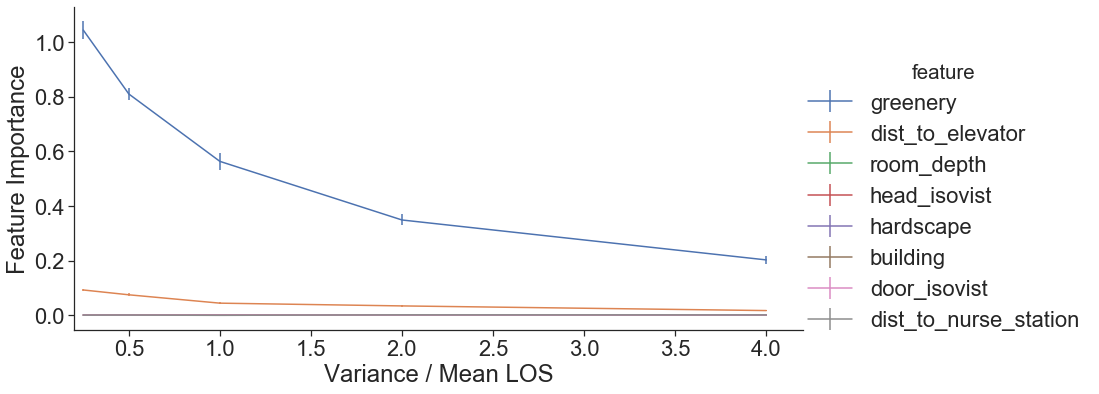

In [33]:
g = sns.FacetGrid(gb_noise_importances_df, hue='feature', height=6, aspect=2)
g = (
    g.map_dataframe(errplot, "variance_coefficient", "importance", "std")
    .set(xlabel='Variance / Mean LOS', ylabel='Feature Importance')
    
).add_legend()
g.ax.set_xlim((0.2, 4.2))
plt.show()